In [1]:
#Generate data
import numpy as np

n = 100
synthetic_data = np.empty((n*n,3))

x = np.linspace(1,20,n)
y = np.linspace(1,20,n)

for i in range(n):
    for j in range(n):
        synthetic_data[i+j*n-1,:] = np.array([x[i],y[j],(x[i]-10.0)-(y[j]-15)])
        #synthetic_data[i+j*n-1,:] = np.array([x[i],y[j],(x[i]-10.0)**2-(y[j]-15)])
        #synthetic_data[i+j*n-1,:] = np.array([x[i],y[j],0.5*(x[i]-10.0)-2*y[j]])


#Shuffle contents
np.random.shuffle(synthetic_data)

<IPython.core.display.Javascript object>


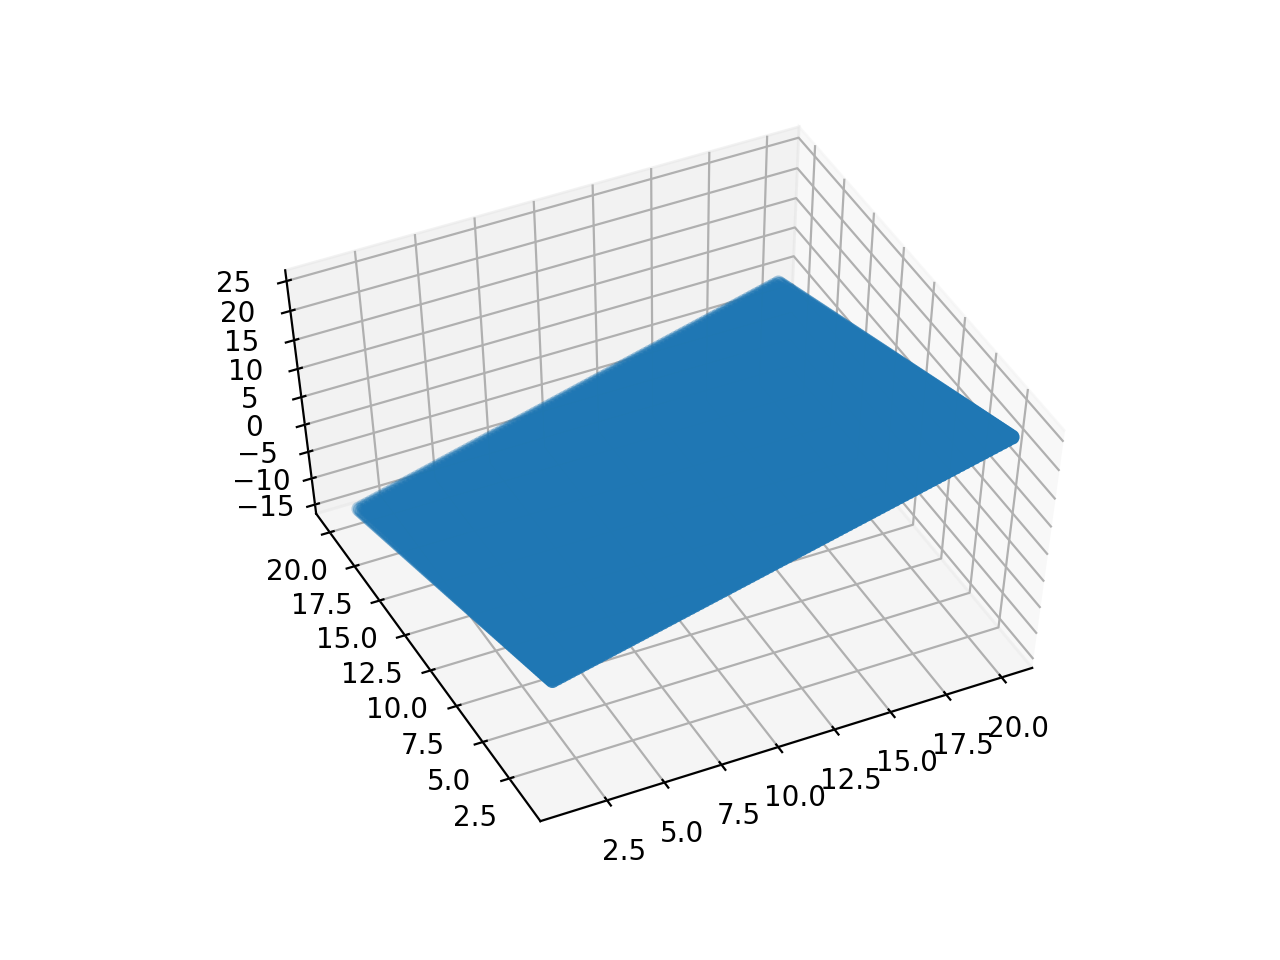

In [2]:
#Graph this data to be sure it is what we want
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import numpy as np
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(synthetic_data[:,0], synthetic_data[:,1], synthetic_data[:,2])

In [3]:
#Helper functions
def normalise(x):
    """Convert values to range 0-1"""
    x_h = (x - x.min())*1.0 / (x.max() - x.min())
    
    return x_h, x.min(), x.max()

def un_normalise(x_h, x_min, x_max):
    """Convert values from range 0-1 back to normal"""
    x = (x_max-x_min)*x_h + x_min
    
    return x

In [4]:
#Now let's try with an autoencoder
import tensorflow as tf
#Prepare for training and validation with a 70:30 split
split_size = int(synthetic_data.shape[0]*0.7)

#Normalise values
#x_in, x_min, x_max = normalise(synthetic_data)

x_in = synthetic_data

#Remember that for autoencoders we don't need to have any targets since the values themselves are the targets
#train_x, val_x = x[:split_size], x[split_size:]


# number of neurons in each layer
input_num_units = 3
hidden_num_units = 2
output_num_units = 3

# define placeholders
x = tf.placeholder(tf.float32, [None, input_num_units])
x_h = tf.placeholder(tf.float32, [None, output_num_units])


# define weights and biases of the neural network 

weights = {
    'hidden': tf.Variable(tf.random_normal([input_num_units, hidden_num_units])),
    'output': tf.Variable(tf.random_normal([hidden_num_units, output_num_units]))
}

biases = {
    'hidden': tf.Variable(tf.random_normal([hidden_num_units])),
    'output': tf.Variable(tf.random_normal([output_num_units]))
}

In [5]:
# hidden = sigmoid(x*w_h+b_h)
hidden_layer = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])
hidden_layer = tf.nn.sigmoid(hidden_layer)
#output_layer = hidden*w_o+b_o
#output_layer = tf.matmul(hidden_layer, weights['output']) + biases['output']
output_layer = tf.matmul(hidden_layer, weights['output']) + biases['output']

#Define cost
cost = tf.reduce_mean(tf.pow(output_layer - x_h, 2))
cross_entropy = -tf.reduce_sum(output_layer*tf.log(x_h))
#Choose Optimiser
optimiser = tf.train.AdamOptimizer(0.001).minimize(cost)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


n_rounds = 20000
batch_size = 1000
loss_vector = np.empty(n_rounds)

0 nan 0.0163875
1000 nan 0.0152275
2000 nan 0.0150468
3000 nan 0.0154936
4000 nan 0.0172261
5000 nan 0.0166584
6000 nan 0.0156406
7000 nan 0.0162454
8000 nan 0.0145944
9000 nan 0.0150349
10000 nan 0.0155208
11000 nan 0.0139383
12000 nan 0.0148604
13000 nan 0.0147619
14000 nan 0.0149653
15000 nan 0.0161153
16000 nan 0.016277
17000 nan 0.0144834
18000 nan 0.0150658
19000 nan 0.0133951


<IPython.core.display.Javascript object>


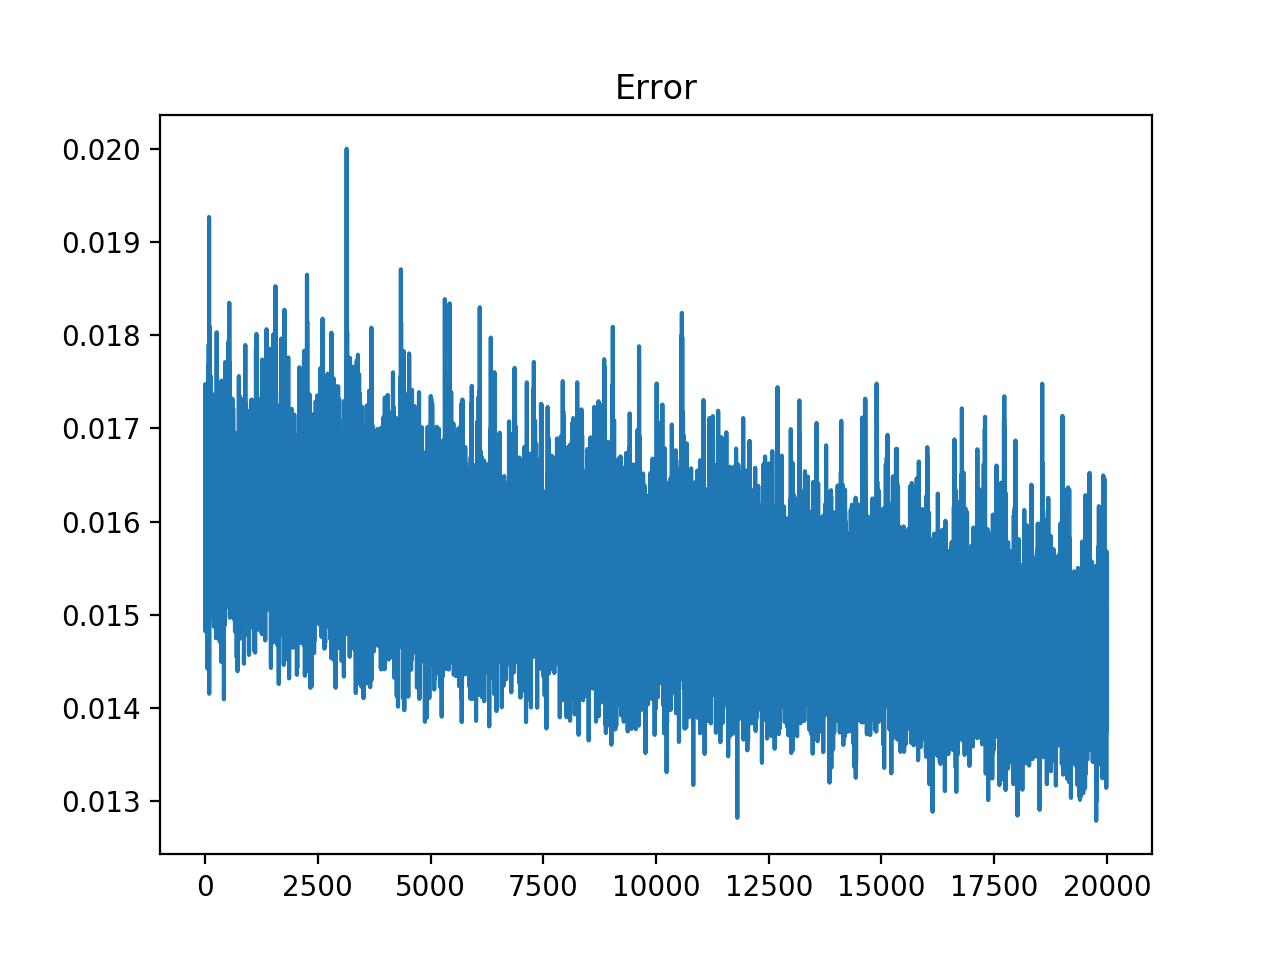

In [18]:
#Training loop

#TODO: add validation since it most likely overfits!

for i in range(n_rounds):
    sample = np.random.randint(n*n, size=batch_size)
    batch_xs = x_in[sample][:]
    batch_ys = x_in[sample][:]
    sess.run(optimiser, feed_dict={x: batch_xs, x_h:batch_ys})
    loss_vector[i] = sess.run(cost, feed_dict={x: batch_xs, x_h:batch_ys})
    if i % 1000 == 0:
        print i, sess.run(cross_entropy, feed_dict={x: batch_xs, x_h:batch_ys}), sess.run(cost, feed_dict={x: batch_xs, x_h:batch_ys})
        
fig = plt.figure()
plt.plot(loss_vector)
plt.title('Error')
plt.show()

In [19]:
print 'W_h:',sess.run(weights['hidden'])
W_h = sess.run(weights['hidden'])
print 'B_h:',sess.run(biases['hidden'])
B_h = sess.run(biases['hidden'])
print 'W_o:',sess.run(weights['output'])
W_o = sess.run(weights['output'])
print 'B_o:',sess.run(biases['output'])
B_o = sess.run(biases['output'])

W_h: [[ 0.45366251  0.68930584]
 [-0.35638463 -0.60210156]
 [-0.45739114 -0.59260219]]
B_h: [ 1.25674748  2.04498053]
W_o: [[  3.98347664  41.50487518 -37.50987625]
 [ 43.26480103   1.46047652  41.79319382]]
B_o: [-13.0778513  -10.92228603   2.84406304]


In [20]:
#downscale synthetic data
reconstructed_data = np.empty((n*n,3))
def sigmoid (x): return 1/(1 + np.exp(-x))  
def relu(x): return np.maximum(x, 0)


for i in range(len(x_in)):    
    reconstructed_data[i,:] = np.dot(sigmoid(np.dot(x_in[i,:],W_h)+B_h),W_o)+B_o
    print np.linalg.norm(reconstructed_data[i,:]-x_in[i,:])
    #print np.mean(np.power(reconstructed_data[i,:]-x_in[i,:],2))
#reconstructed_data = un_normalise(reconstructed_data, x_min, x_max)

0.275039355524
0.163891881241
0.275842313992
0.193618215238
0.141736482471
0.169924543317
0.327859900278
0.0954939838682
0.0683249992347
0.294318458648
0.137045726883
0.202694497307
0.105722744698
0.155991608364
0.238547178418
0.0868591377352
0.16934620505
0.101190358868
0.158427270368
0.0431568995757
0.26189413556
0.10582799194
0.0459892772896
0.143006754436
0.168950873002
0.115918415801
0.36048694763
0.18025632481
0.162213031168
0.32213296261
0.459009658313
0.245672773686
0.161810620969
0.384428565479
0.202106319385
0.0704512734026
0.172295932885
0.0792057812373
0.165490121806
0.0393191623438
0.337209238951
0.0678237443008
0.210931550851
0.168035478085
0.128789376138
0.260218458678
0.238010657085
0.126056297137
0.171422426286
0.138321055033
0.190804499801
0.275130980344
0.128372827123
0.0839174598387
0.524605024752
0.178650888598
0.241687034565
0.0441749979507
0.282131350744
0.0477189239329
0.235785474158
0.307543273944
0.130310556728
0.162565856604
0.147292181467
0.1094500752
0.1684

0.214134202808
0.116596215561
0.384712476082
0.0947884940373
0.158453523152
0.163973797525
0.107615316627
0.126175802286
0.416333128867
0.1659349592
0.133244178707
0.240799619589
0.203305479356
0.321050632562
0.34602705113
0.161565863305
0.209226917393
0.221688170877
0.114351910259
0.16020787201
0.182434108506
0.195584139473
0.209705018735
0.182760526806
0.096125958645
0.177102688811
0.114625106591
0.0757509323759
0.131946428743
0.232988404561
0.547398095476
0.369043052152
0.127784999714
0.054714045768
0.0879584710815
0.163989856407
0.192325920475
0.184195349068
0.125639437599
0.0397766605883
0.142563854688
0.158118227095
0.122795579681
0.314130353885
0.274781289589
0.275014014754
0.211320141421
0.0789587474647
0.289061594975
0.241542102814
0.166254201235
0.0698060465344
0.124839086562
0.171289614923
0.16762056458
0.305893946216
0.508183675082
0.245950577292
0.294802977974
0.276090491858
0.146521766243
0.158283356201
0.342873164712
0.155606279363
0.271852614905
0.36954118352
0.15041977

0.134236695596
0.178762480316
0.282047002839
0.138589240525
0.229169013103
0.282103656862
0.232845093997
0.214584949001
0.0825270190271
0.170544322851
0.160093583385
0.39486267424
0.200337668923
0.207823554375
0.0222791060985
0.26062805122
0.0983378423881
0.0616241566804
0.2742736754
0.208616832659
0.313642091696
0.144173440039
0.178403441536
0.1847276413
0.0905719826669
0.138669262876
0.125864954631
0.214097026672
0.138593831308
0.165550766908
0.115868604159
0.190398542453
0.455508053984
0.151492203449
0.222460047603
0.481178409798
0.331362331056
0.177477787103
0.152295155104
0.242611999802
0.367615350522
0.33699640299
0.288015797887
0.159697982602
0.266844081027
0.154711945975
0.0670407099185
0.176366619579
0.387720123562
0.186665086369
0.195649669775
0.139232499039
0.166505904379
0.240169393474
0.185620216978
0.184926310261
0.273789791584
0.144204593871
0.065591500851
0.294787642776
0.242077011584
0.175508885361
0.235586533433
0.16349776619
0.0444932732019
0.3440831072
0.10609578777

0.123527109878
0.127417149598
0.0340999128111
0.0420569134244
0.133130590815
0.176887907796
0.0869088533053
0.115225091938
0.211942234863
0.201898499354
0.132957983943
0.240649008488
0.22605444256
0.161573408007
0.217720230331
0.142843557452
0.327030081928
0.248004713767
0.195974657993
0.231719713248
0.327040974574
0.242420303262
0.138610998629
0.163358059094
0.141610600187
0.162251779751
0.119450079073
0.365573746126
0.0933067811485
0.0470866635962
0.0659094192282
0.141779173773
0.330016317751
0.253970637364
0.234637038583
0.0698015649059
0.153907471886
0.361124066799
0.105294571378
0.103004056562
0.0903731995125
0.170650724038
0.168573838553
0.173976504938
0.256538467018
0.130699329423
0.333050959027
0.256573669258
0.262863293876
0.130010364945
0.0901746083657
0.244266117507
0.155218845085
0.130071543938
0.114718310475
0.204336240326
0.326564834351
0.239283366559
0.123220061482
0.13899356572
0.284644943812
0.109340645786
0.192470716887
0.322055425019
0.206572651132
0.165959366959
0.0

0.341710174663
0.1614135408
0.094666764103
0.355646646919
0.243129955489
0.199221359532
0.100275002153
0.227162013866
0.270090537058
0.217064982221
0.289886349933
0.159822504207
0.0669725118033
0.239228764156
0.704926432416
0.318819251238
0.147544271248
0.303153381789
0.265089896949
0.106536946282
0.239993207746
0.348560089116
0.292806172383
0.251017561782
0.13202490724
0.151241135891
0.0628904456515
0.281046444
0.198192728608
0.169879674707
0.13378135333
0.190731728277
0.298205617584
0.160576428686
0.18303460287
0.162379733181
0.114719099209
0.145291414592
0.20774208333
0.15742701871
0.0832201669662
0.161345071492
0.0897348903058
0.300037360219
0.138588103673
0.109287492364
0.215038317335
0.175694652273
0.0625983228787
0.084394146432
0.373636220956
0.2934489399
0.252025879312
0.276223168972
0.177082819236
0.346410953054
0.156538875744
0.502337471073
0.272194986529
0.221786157065
0.224065610067
0.161517571282
0.161563383691
0.455130992117
0.243402138529
0.115225343861
0.368846179967
0.

0.272818539505
0.251442140926
0.159556966587
0.252392075152
0.163499752497
0.163655873256
0.135679085481
0.20445692165
0.368421767358
0.165753866676
0.149152700324
0.141479017151
0.0897524157871
0.15413942204
0.2700468985
0.193906546733
0.220899084837
0.288936046376
0.197682062446
0.223851898905
0.284250829175
0.104529009854
0.1740880625
0.303945289045
0.0343842545687
0.15251337399
0.115105501171
0.233608834999
0.222353659227
0.112835596211
0.45017637248
0.104745125066
0.288253131784
0.219294820606
0.0458114377613
0.157226106348
0.12661375245
0.315261483398
0.194771005785
0.15948182332
0.237495099051
0.0766340342981
0.147403056446
0.0396655490482
0.0864063602088
0.109408093189
0.136212495479
0.115652620025
0.171533208201
0.200988169972
0.238765831624
0.293798310108
0.185742531613
0.201826155189
0.26980267682
0.173743573333
0.192988985118
0.146503611039
0.105446796604
0.167671248167
0.13519593701
0.263231272373
0.231496690303
0.238738871612
0.190876349831
0.174410647525
0.083358749871
0

<IPython.core.display.Javascript object>


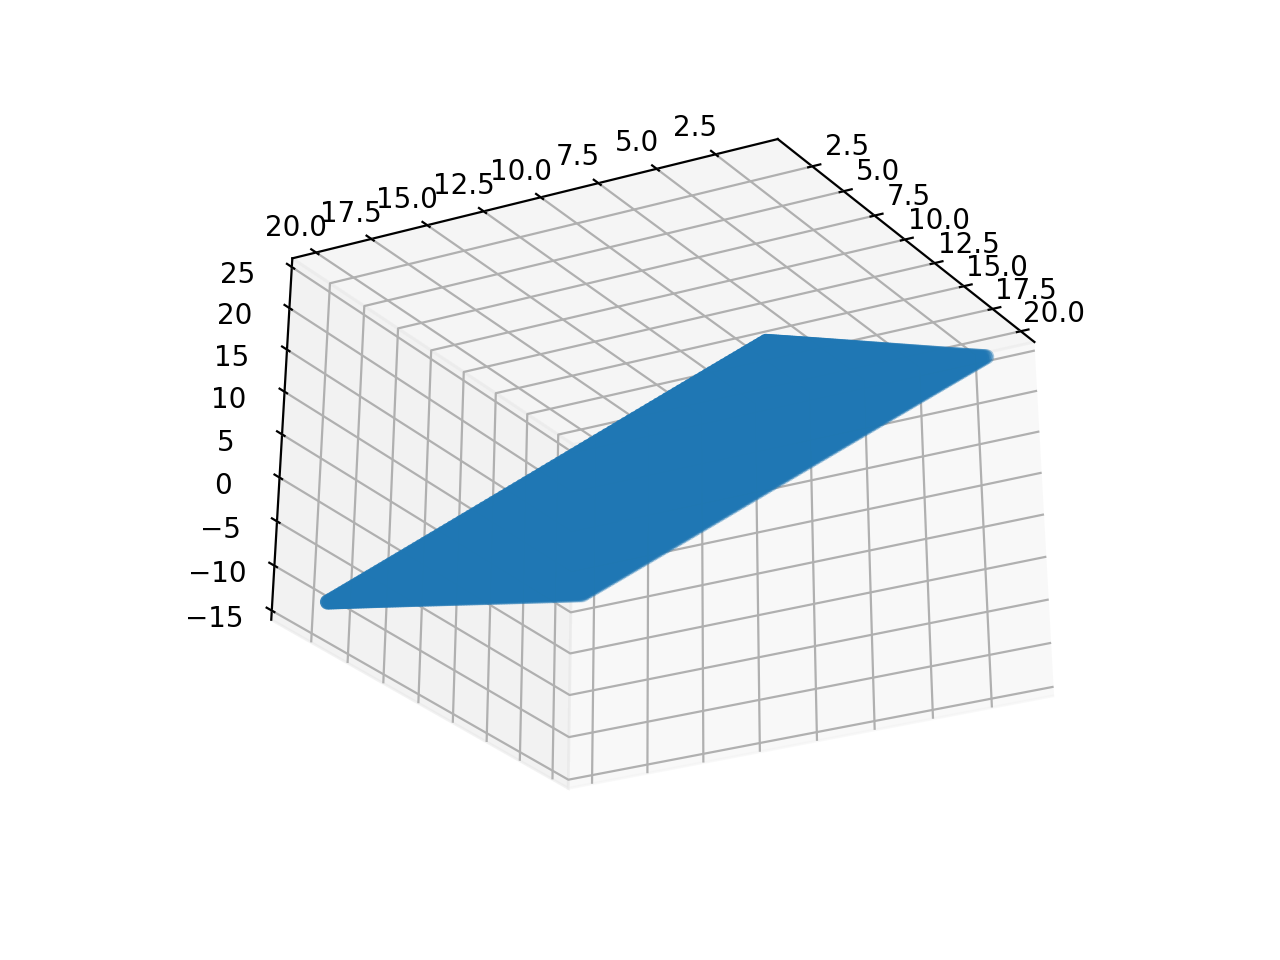

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reconstructed_data[:,0], reconstructed_data[:,1], reconstructed_data[:,2])

In [10]:
np.savetxt('reconstructed.csv', reconstructed_data, delimiter=",")
np.savetxt('synthetic.csv', synthetic_data, delimiter=",")